<a href="https://colab.research.google.com/github/CVH4OYC/ML_lab/blob/main/%D0%A4%D0%9C%D0%98_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%90%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection Using Autoencoder

## Deep learning

Итак, мы добрались и до глубокого обучения. Все указанные выше классические методы были довольно требовательны: нам приходилось усердно работать с данными и параметрами самих моделей, чтобы добиться результата. Есть ли альтернатива?

### Автокодировщик

<img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2018/03/autoencoder.jpeg?w=638&ssl=1" width=800>

Как видно из рисунка, автокодировщик имеет ту же архитектуру, что и обычный MLP (многослойный перцептрон), за исключением требования, чтобы количество входных нейронов было равно количеству нейронов в выходном слое. Автокодировщик во время обучения выучивает внутренние представления данных так, чтобы по входу можно было реконструировать выход. Таким образом, это означает, что автокодировщик не может просто копировать ввод в вывод, он вынужден изучать наиболее важные признаки ввода и отбрасывать остальные.

Как мы можем использовать автокодировщик для обнаружения мошеннических транзакций? Автокодировщиком мы пытаемся оптимизировать модель (то есть параметры модели), чтобы минимизировать ошибку реконструкции.

Теперь предположим, что мы подаем цифру 5 и на выходе получаем восстановленную цифру 5 с минимальной ошибкой восстановления. Теперь попробуем скормить другую цифру, которая пытается имитировать 5, когда мы получим на выходах ее восстановленную версию, она будет с большой ошибкой реконструкции. Это логика использования автокодировщика для обнаружения мошенничества. На вход подаем вектор из признаков (30 признаков).

## Declare required dependencies

In [ ]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42


## Data ingestion

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/heart_2022_no_nans.csv')

## Data exploration

In [ ]:
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [ ]:
LABELS = ["No", "Yes"]

In [ ]:
df.shape


(246022, 40)

In [ ]:
df.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,246022.000000,246022.000000,246022.000000,246022.000000,246022.000000,246022.000000
mean,4.119026,4.167140,7.021331,1.705150,83.615179,28.668136
std,8.405844,8.102687,1.440681,0.106654,21.323156,6.513973
min,0.000000,0.000000,1.000000,0.910000,28.120000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.270000
50%,0.000000,0.000000,7.000000,1.700000,81.650000,27.460000
75%,3.000000,4.000000,8.000000,1.780000,95.250000,31.890000
max,30.000000,30.000000,24.000000,2.410000,292.570000,97.650000


In [ ]:
df.describe(include=['O'])

,State,Sex,GeneralHealth,LastCheckupTime,PhysicalActivities,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,...,ChestScan,RaceEthnicityCategory,AgeCategory,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
count,246022,246022,246022,246022,246022,246022,246022,246022,246022,246022,...,246022,246022,246022,246022,246022,246022,246022,246022,246022,246022
unique,54,2,5,4,2,4,2,2,2,2,...,2,5,13,2,2,2,2,4,2,3
top,Washington,Female,Very good,Within past year (anytime less than 12 months ...,Yes,None of them,No,No,No,No,...,No,"White only, Non-Hispanic",Age 65 to 69,Yes,No,Yes,No,"No, did not receive any tetanus shot in the pa...",No,No
freq,15000,127811,86999,198153,191318,131592,232587,231069,235910,209493,...,141822,186336,28557,135307,161520,131196,146130,81747,235446,167306


## Ести ли пропуски?

In [ ]:
df.isnull().values.any()

False

## Class distribution ( 0 - non fraudulent, 1 - fraudulent)

In [ ]:
df['HadHeartAttack'].value_counts()

,count
HadHeartAttack,
No,232587
Yes,13435


<ipython-input-12-a0a0eb8e491d>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['HadHeartAttack'], sort = True)


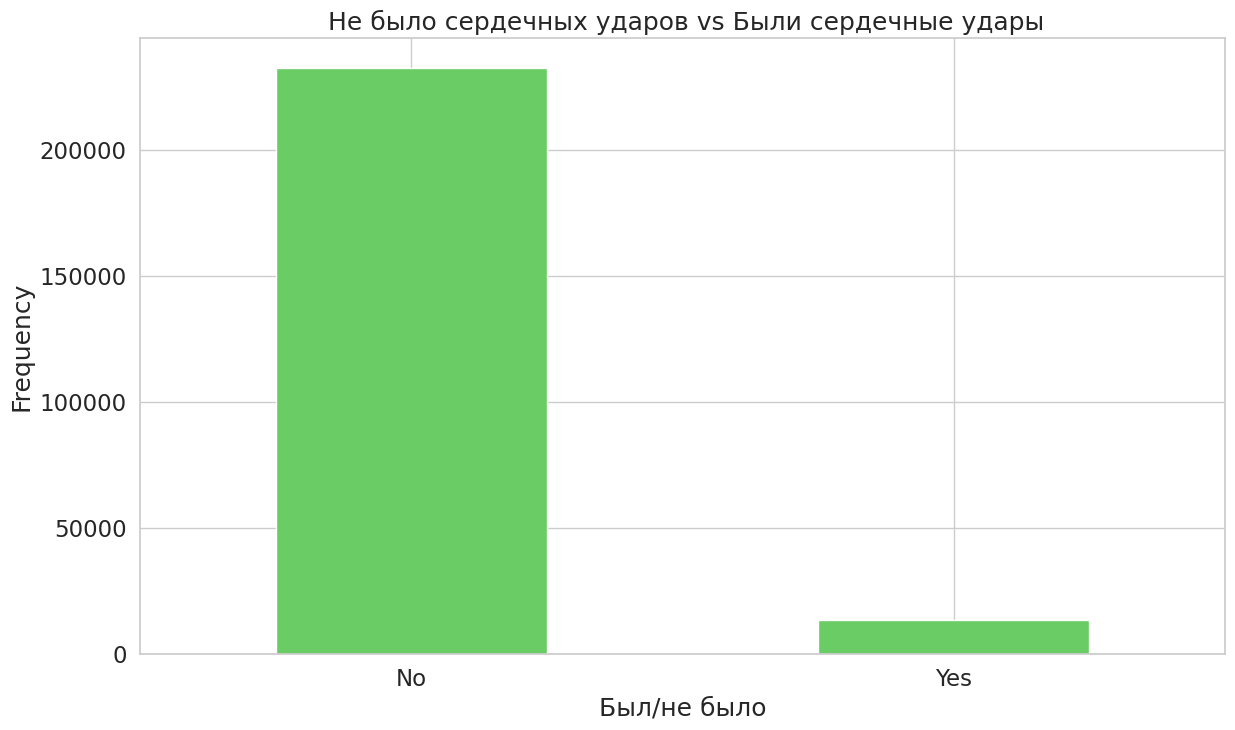

In [ ]:
count_classes = pd.value_counts(df['HadHeartAttack'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title(" Не было сердечных ударов vs Были сердечные удары")
plt.xticks(range(2), LABELS)
plt.xlabel("Был/не было")
plt.ylabel("Frequency");

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
categorical_cols = df.select_dtypes(include=['object']).columns
encoder = OrdinalEncoder()

for col in categorical_cols:
    unique_values = df[col].nunique()  # Количество уникальных значений в колонке

    if unique_values <= 5:
        # Кодируем с помощью pd.get_dummies
        df[col] = encoder.fit_transform(df[[col]])
    else:
        # Удаляем колонку
        df = df.drop(columns=[col])

In [ ]:
df

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,0.0,4.0,4.0,0.0,3.0,1.0,9.0,3.0,0.0,0.0,...,1.60,71.67,27.99,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1,1.0,4.0,0.0,0.0,3.0,1.0,6.0,3.0,0.0,0.0,...,1.78,95.25,30.13,0.0,0.0,1.0,1.0,2.0,0.0,0.0
2,1.0,4.0,0.0,0.0,3.0,0.0,8.0,1.0,0.0,0.0,...,1.85,108.86,31.66,1.0,0.0,0.0,1.0,0.0,0.0,2.0
3,0.0,1.0,5.0,0.0,3.0,1.0,9.0,3.0,0.0,0.0,...,1.70,90.72,31.32,0.0,0.0,1.0,1.0,0.0,0.0,2.0
4,0.0,2.0,3.0,15.0,3.0,1.0,5.0,0.0,0.0,0.0,...,1.55,79.38,33.07,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246017,1.0,4.0,0.0,0.0,1.0,1.0,6.0,3.0,0.0,0.0,...,1.78,102.06,32.28,1.0,0.0,0.0,0.0,2.0,0.0,0.0
246018,0.0,1.0,0.0,7.0,3.0,1.0,7.0,3.0,0.0,0.0,...,1.93,90.72,24.34,0.0,0.0,0.0,0.0,0.0,0.0,2.0
246019,1.0,2.0,0.0,15.0,3.0,1.0,7.0,0.0,0.0,0.0,...,1.68,83.91,29.86,1.0,1.0,1.0,1.0,2.0,0.0,2.0
246020,0.0,0.0,2.0,2.0,3.0,1.0,7.0,3.0,0.0,0.0,...,1.70,83.01,28.66,0.0,1.0,1.0,0.0,2.0,0.0,0.0


In [ ]:
df['HadHeartAttack'].value_counts()

,count
HadHeartAttack,
0.0,232587
1.0,13435


Наш набор данных очень сильно несбалансирован в пользу отрицательного (No, то есть нормального) класса. Это требует дальнейшего изучения данных

In [ ]:
heartAttackDF = df[df.HadHeartAttack == 1]
normalDF = df[df.HadHeartAttack	 == 0]

In [ ]:
heartAttackDF.shape

(13435, 38)

In [ ]:
normalDF.shape

(232587, 38)

<Axes: >

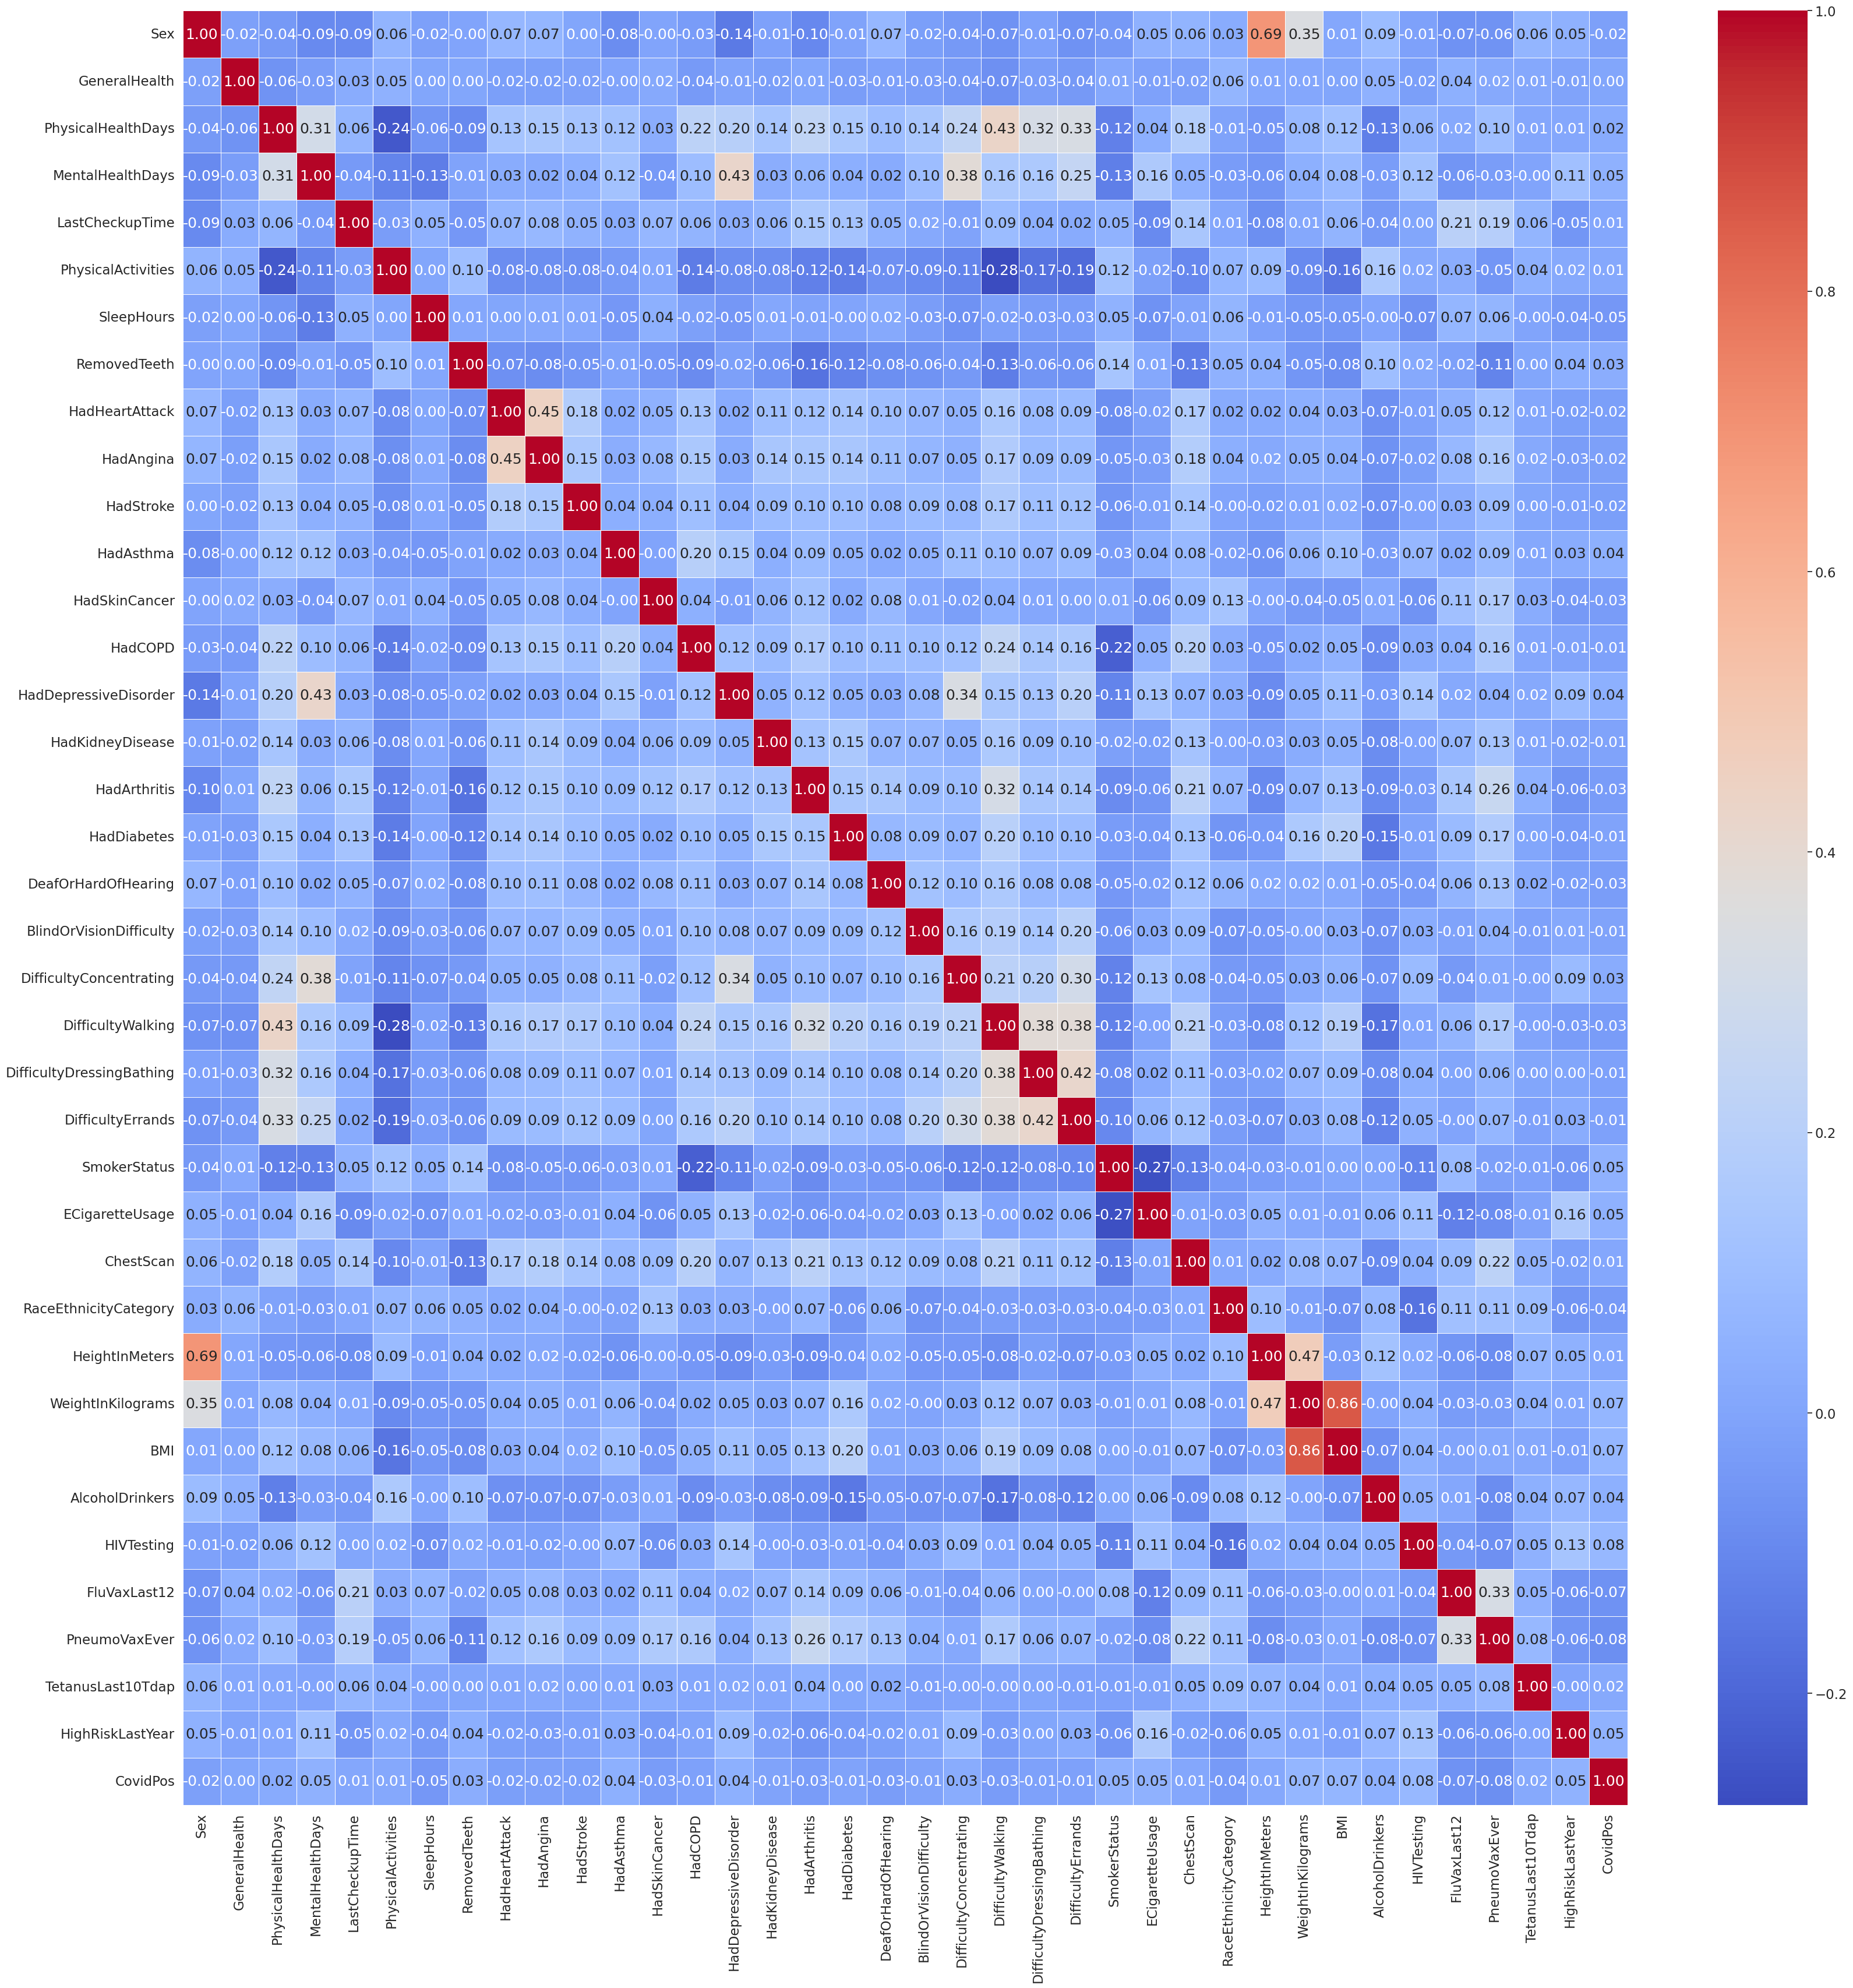

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = df.corr()

plt.figure(figsize=(40,40))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

In [ ]:
# Выбираем корреляции для 'HadHeartAttack'
had_heart_attack_corr = corr['HadHeartAttack']

# Находим столбцы с корреляцией по модулю >= 0.07
relevant_columns = had_heart_attack_corr[abs(had_heart_attack_corr) >= 0.07].index

# Оставляем только эти столбцы в DataFrame
df = df[relevant_columns]

In [ ]:
df.shape

(246022, 20)

### Разделите набор данных на наборы обучающих и тестовых данных.

Мы разделили набор данных как обучение = 80% и тест = 20%. В обучающем наборе данных будут только строки без информации о сердечных ударах, а в тестовом наборе данных будут как случаи с сердечными ударами, так и без них.

In [ ]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.HadHeartAttack == 0]
X_train = X_train.drop(['HadHeartAttack'], axis=1)
#print(type(X_train))
y_test = X_test['HadHeartAttack']
X_test = X_test.drop(['HadHeartAttack'], axis=1)

X_train = X_train.values
#print(type(X_train))
X_test = X_test.values
y_test = y_test.values
print(y_test.size)


49205


## Model
Мы построим автоэнкодер, состоящий из 4 полносвязных слоев с 14,7,7,29 нейронами. Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер. Обратите внимание, что последний слой имеет 19 узлов, соответствующих 19 функциям в элементе входных данных.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(19, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(7, 7),
           nn.Tanh(),
           nn.Linear(7, 19),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Autoencoder().double()
#model = Autoencoder().double().cpu()

In [ ]:
num_epochs = 100   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 32
learning_rate = 1e-3

**minibatch_size** - размер мини-пакета - это количество записей (или векторов), которые мы одновременно передаем в наш алгоритм обучения. Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов  мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик.
По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.


**learning_rate** - скорость оптимизации (обучения). Насколько маленькими шашами мы изменяем градиент.

In [ ]:

train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)


In [ ]:

#test = data_utils.TensorDataset(torch.from_numpy(X_test).double(),torch.from_numpy(y_test).double())
#test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)


In [ ]:
history = {}
history['train_loss'] = []
history['test_loss'] = []


In [ ]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './heart_attack_model.pth')

epoch [1/100], loss:1.0774
epoch [2/100], loss:0.0954
epoch [3/100], loss:0.0739
epoch [4/100], loss:0.0687
epoch [5/100], loss:0.0669
epoch [6/100], loss:0.0641
epoch [7/100], loss:0.0592
epoch [8/100], loss:0.0548
epoch [9/100], loss:0.0460
epoch [10/100], loss:0.0448
epoch [11/100], loss:0.0442
epoch [12/100], loss:0.0438
epoch [13/100], loss:0.0435
epoch [14/100], loss:0.0431
epoch [15/100], loss:0.0429
epoch [16/100], loss:0.0425
epoch [17/100], loss:0.0423
epoch [18/100], loss:0.0421
epoch [19/100], loss:0.0419
epoch [20/100], loss:0.0418
epoch [21/100], loss:0.0417
epoch [22/100], loss:0.0417
epoch [23/100], loss:0.0417
epoch [24/100], loss:0.0416
epoch [25/100], loss:0.0416
epoch [26/100], loss:0.0415
epoch [27/100], loss:0.0414
epoch [28/100], loss:0.0414
epoch [29/100], loss:0.0413
epoch [30/100], loss:0.0412
epoch [31/100], loss:0.0411
epoch [32/100], loss:0.0411
epoch [33/100], loss:0.0410
epoch [34/100], loss:0.0410
epoch [35/100], loss:0.0410
epoch [36/100], loss:0.0409
e

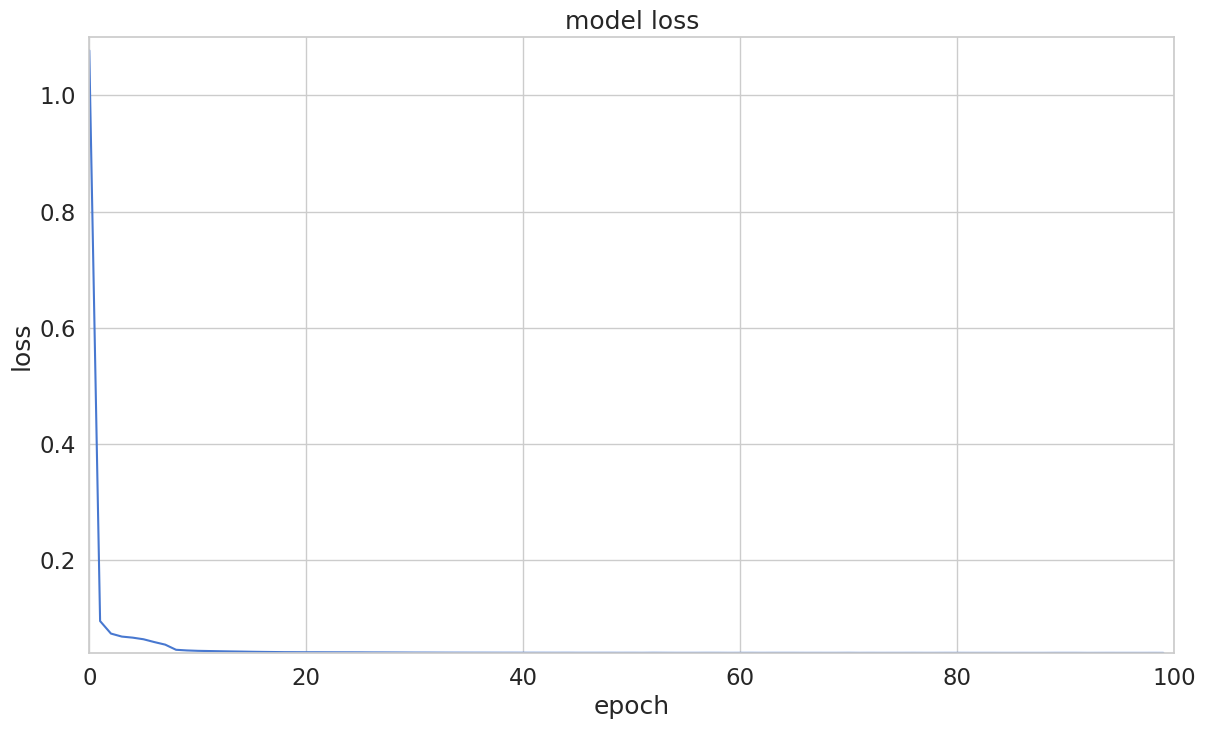

In [ ]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,100,0.04,1.1])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

## Оценка модели

In [ ]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['HadHeartAttack'] = y_test

In [ ]:
reconstructionErrorDF.describe()

,pred_loss,HadHeartAttack
count,49205.000000,49205.000000
mean,0.043509,0.053490
std,0.053506,0.225012
min,0.000147,0.000000
25%,0.002893,0.000000
50%,0.019466,0.000000
75%,0.063304,0.000000
max,0.417040,1.000000


# Reconstruction Errors without attack

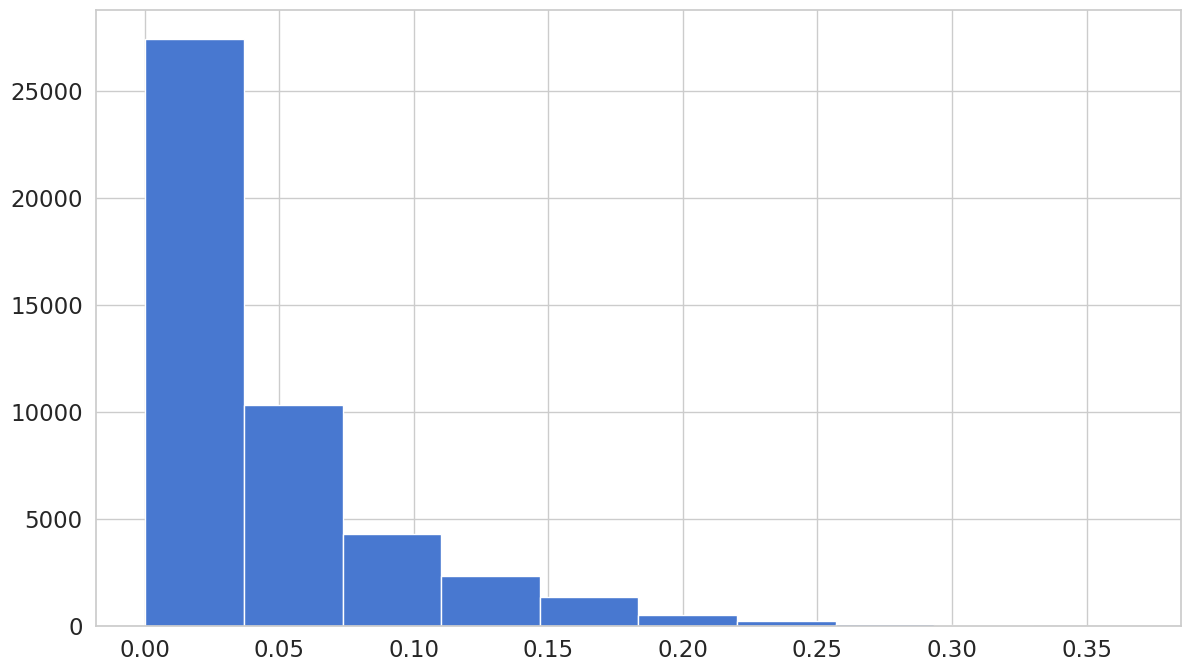

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['HadHeartAttack']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Reconstruction Errors with attack

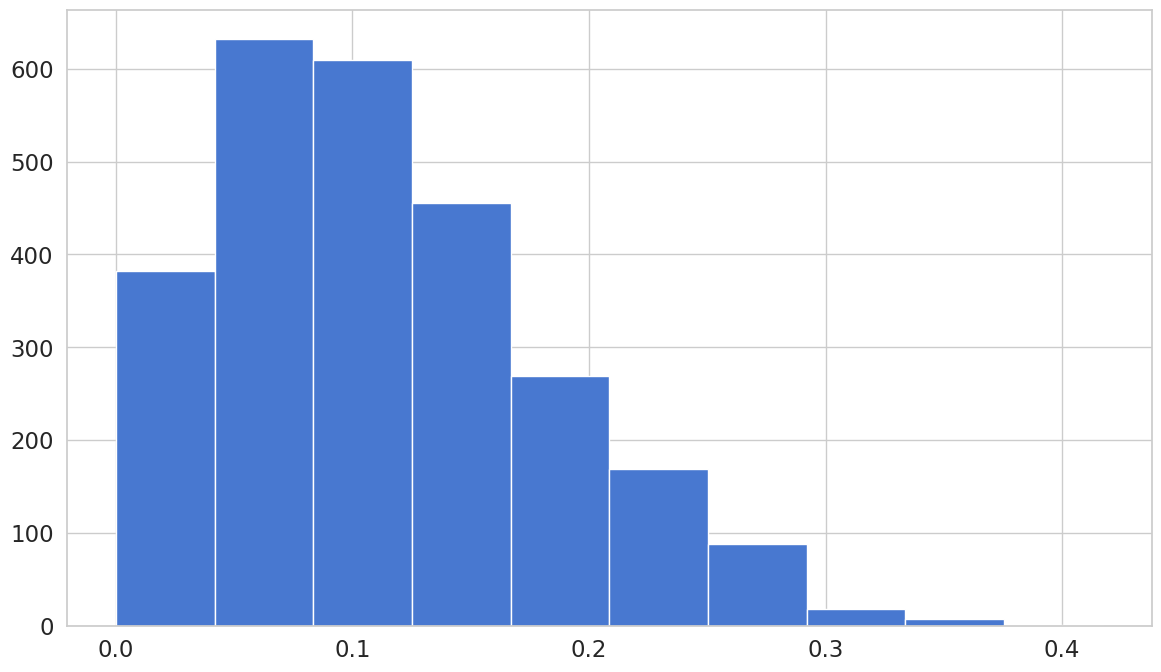

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['HadHeartAttack']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

## ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

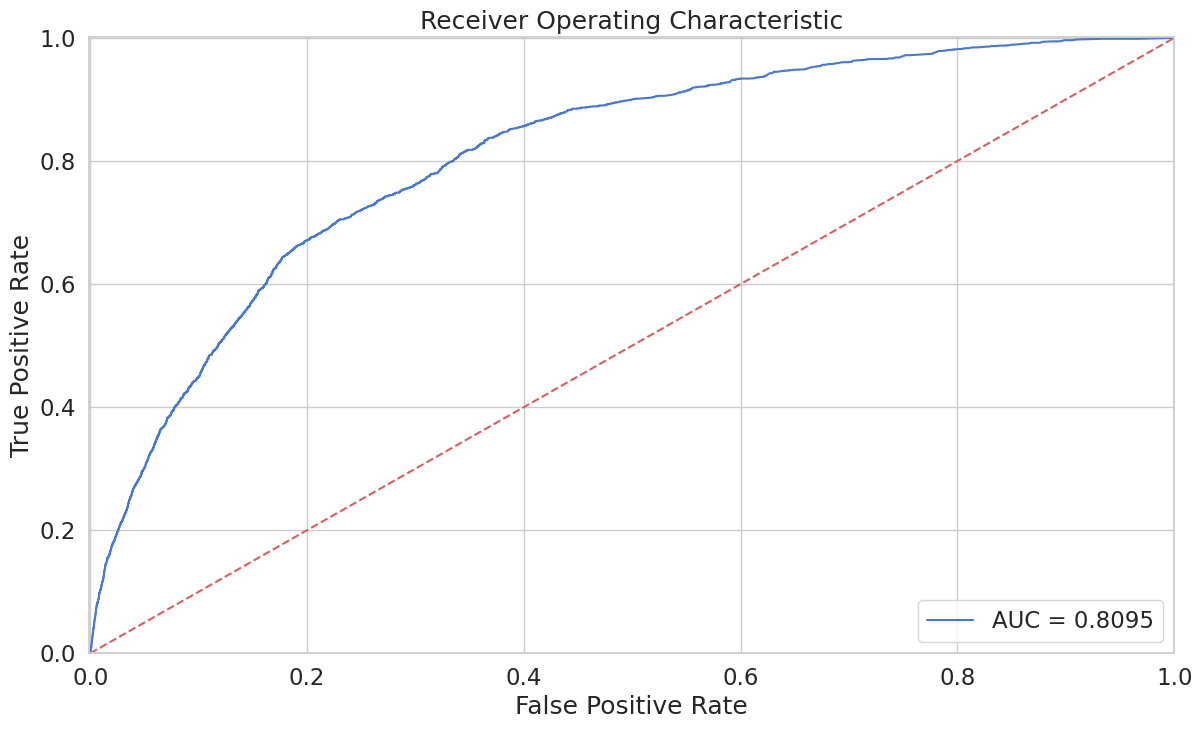

In [ ]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.HadHeartAttack, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

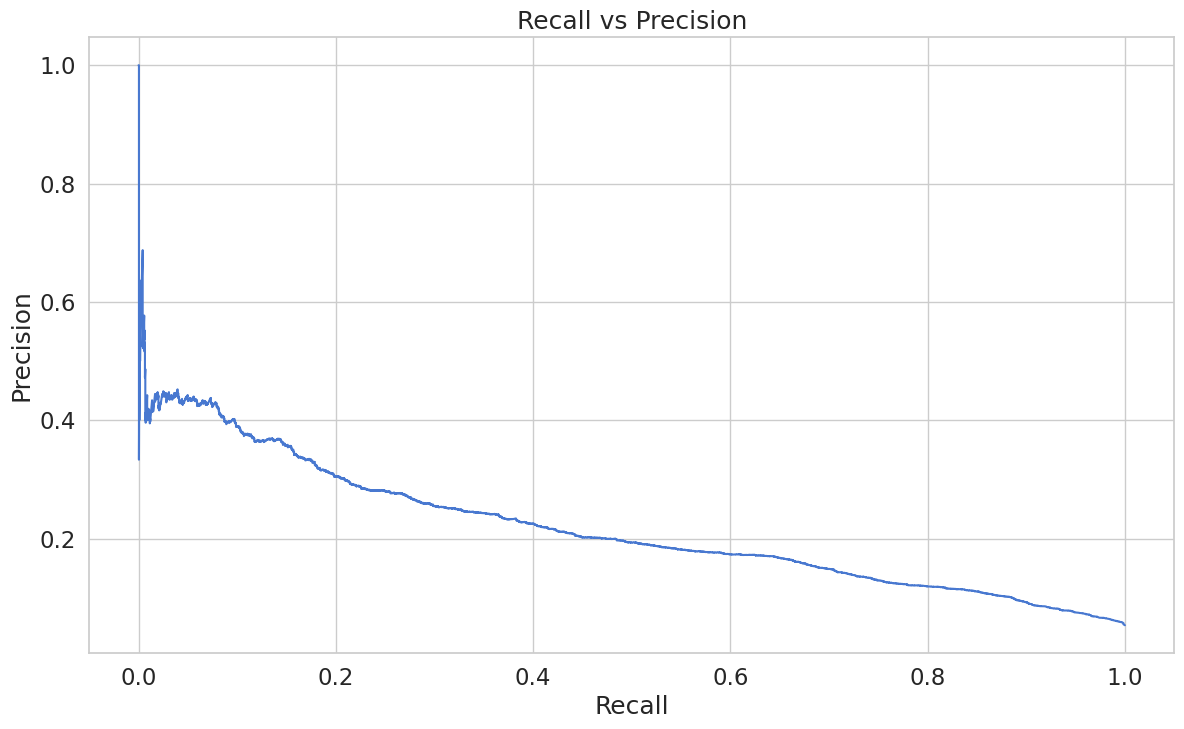

In [ ]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.HadHeartAttack, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

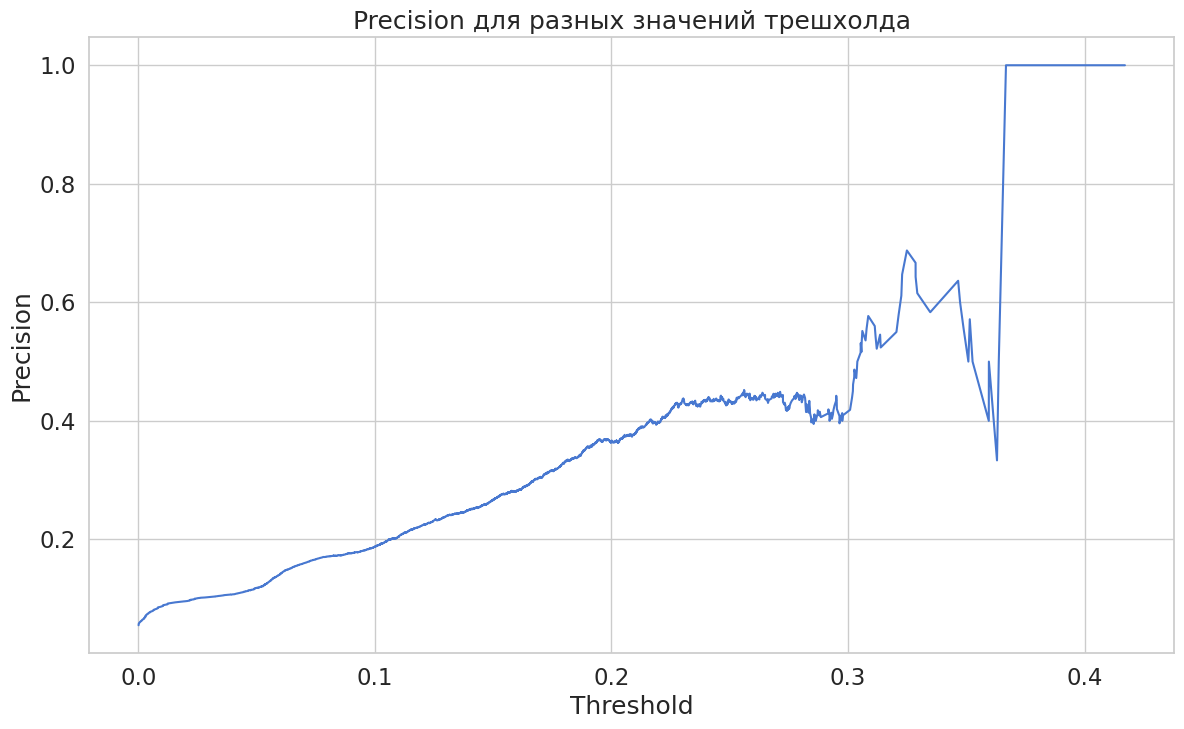

In [ ]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


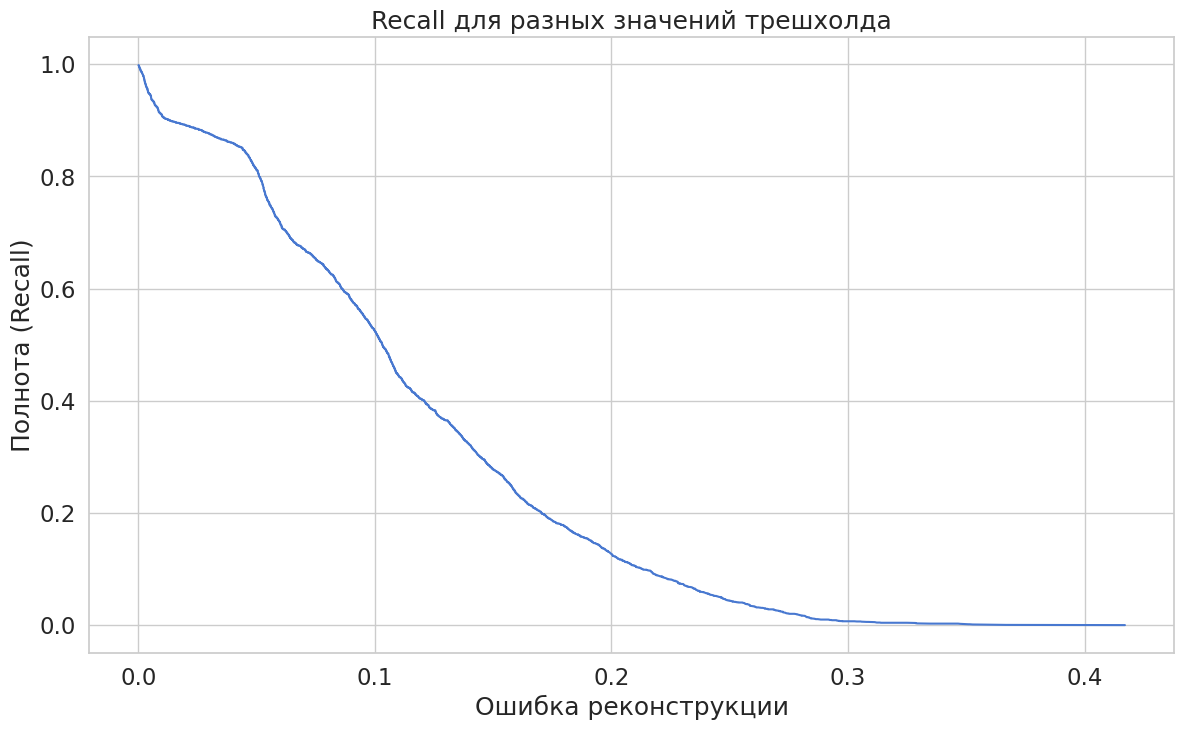

In [ ]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

## Используем модель для того, чтобы сделать предсказание

Чтобы предсказать, является ли новая/невидимая транзакция нормальной или мошеннической, мы рассчитаем ошибку реконструкции на основе самих данных транзакции. Если ошибка превышает предопределенный порог, мы помечаем ее как мошенничество (поскольку наша модель должна иметь низкую ошибку при обычных транзакциях). Давайте выберем это значение:

In [ ]:
threshold = 0.1

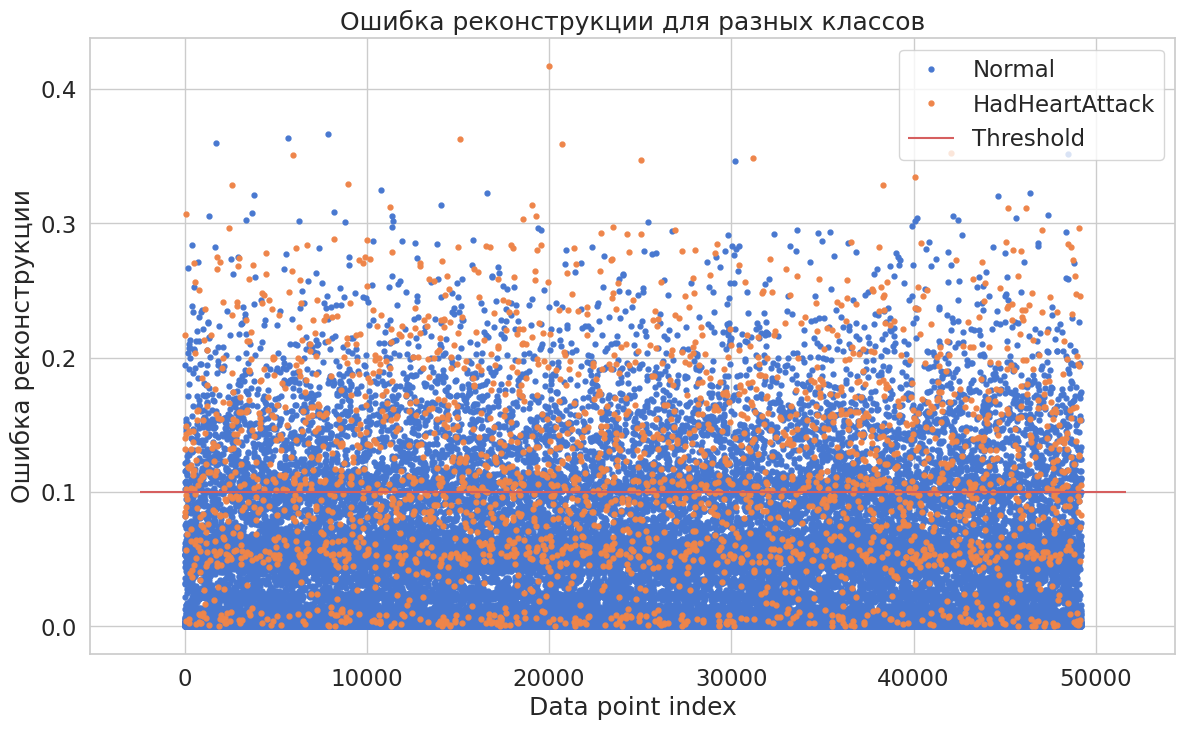

In [ ]:
groups = reconstructionErrorDF.groupby('HadHeartAttack')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "HadHeartAttack" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

Построим и посмотрим confusion matrix:

<ipython-input-63-360883028520>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'));


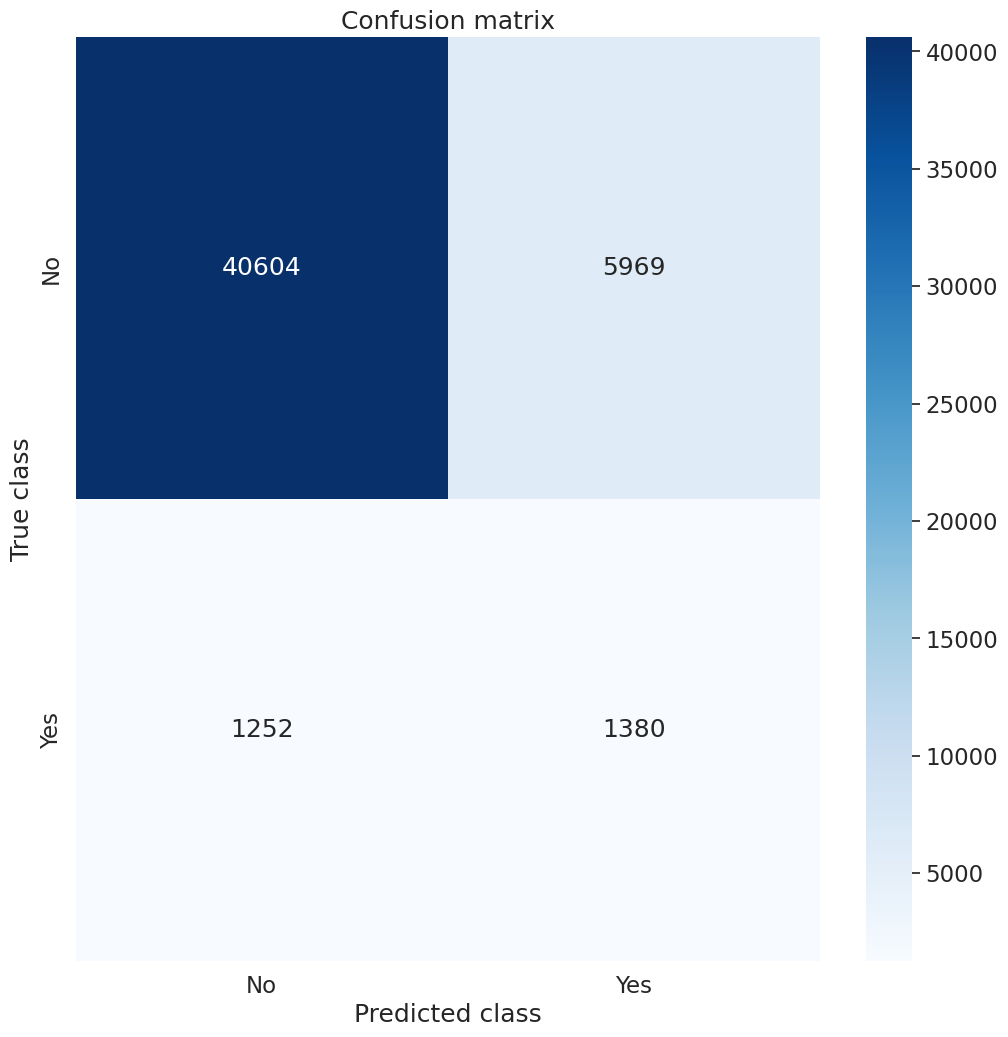

In [ ]:

y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.HadHeartAttack, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

**Вывод**

Вне зависимости от значения трешхолда, TP будет низким